# Settings



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1frDnf9WlKo5BmWdjie-S6d4Vd97dEIV8#scrollTo=gpQcsBEFblNr)


In [ ]:
import os
from getpass import getpass
user = getpass('User')
password = getpass('Pwd')
os.environ['GITHUB_AUTH'] = user + ':' + password

!git clone https://$GITHUB_AUTH@github.com/collectif-codata/case7-lockdown-exit-strategy.git

User··········
Pwd··········
Cloning into 'case7-lockdown-exit-strategy'...
remote: Enumerating objects: 474, done.
remote: Counting objects: 100% (474/474), done.
remote: Compressing objects: 100% (257/257), done.
remote: Total 474 (delta 263), reused 409 (delta 202), pack-reused 0
Receiving objects: 100% (474/474), 10.91 MiB | 14.72 MiB/s, done.
Resolving deltas: 100% (263/263), done.


In [ ]:
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotnine import *
from scipy.optimize import minimize

In [ ]:
if not 'covid' in os.listdir():
    sys.path.append('case7-lockdown-exit-strategy')
    
import covid

# Loading

In [ ]:
from covid.dataset import fetch_daily_case

In [ ]:
data = fetch_daily_case(update=True, return_data=True)

data = (
    data
    .query('source_nom == "Ministère des Solidarités et de la Santé"')
    .query('granularite == "pays"')
    .filter(['date', 'cas_confirmes', 'hospitalises', 'gueris', 'deces'])
    .assign(date=lambda x: pd.to_datetime(x['date']))
    .set_index('date')
)

dates = data.index
start_date = dates.min()
end_date = dates.max()

print(start_date, end_date)

2020-01-24 00:00:00 2020-04-28 00:00:00


/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 33 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


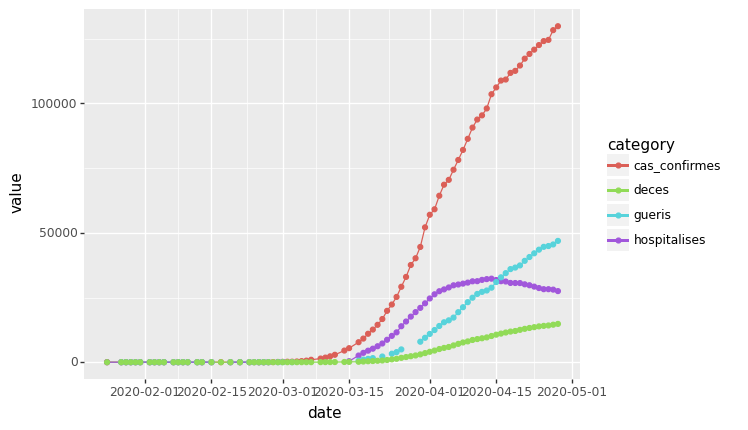

<ggplot: (8741742437952)>

In [ ]:
data_ = (
    data
    .reset_index()
    .melt(id_vars=['date'], var_name='category', value_name='value')
)

(
    ggplot(data_)
    + aes(x='date', y='value', color='category')
    + geom_line()
    + geom_point()
)

# Model

## Prior knowledge

In [ ]:
from covid.models import SIR

In [ ]:
N = int(6.5e7)
I0 = 2
init_state = (N-I0, I0, 0)

gamma_0 = 1/4
R0 = 5
beta_0 = gamma_0 * R0

params_0 = (beta_0, gamma_0)

In [ ]:
def solve_sir(params):
    
    beta, gamma = params

    model = SIR(N, beta, gamma)
    res = model.solve(init_state, start_date=start_date)
    
    s_pred = res.loc[dates]['S']
    r_pred = res.loc[dates]['R']
    i_pred = res.loc[dates]['I']
    
    return np.array(i_pred)

In [ ]:
%%time
i_pred_0 = solve_sir(params_0)

CPU times: user 401 ms, sys: 0 ns, total: 401 ms
Wall time: 401 ms


In [ ]:
def sse(params):
    i_pred = solve_sir(params)
    sse = np.sum((i_pred-data['cas_confirmes'])**2)
    return sse

In [ ]:
%%time
print("SSE:", sse(params_0))

SSE: 3179923309900701.5
CPU times: user 390 ms, sys: 134 µs, total: 390 ms
Wall time: 390 ms


In [ ]:
%%time
msol = minimize(sse,[beta_0,gamma_0],method='Nelder-Mead', options={'disp': True})
print(msol)

Optimization terminated successfully.
         Current function value: 10313432578.733643
         Iterations: 153
         Function evaluations: 332
 final_simplex: (array([[2.29946828, 2.15465618],
       [2.29946828, 2.15465618],
       [2.29946828, 2.15465618]]), array([1.03134326e+10, 1.03134326e+10, 1.03134326e+10]))
           fun: 10313432578.733643
       message: 'Optimization terminated successfully.'
          nfev: 332
           nit: 153
        status: 0
       success: True
             x: array([2.29946828, 2.15465618])
CPU times: user 58.8 s, sys: 5.27 ms, total: 58.8 s
Wall time: 58.8 s


In [ ]:
sol = solve_sir(msol.x)

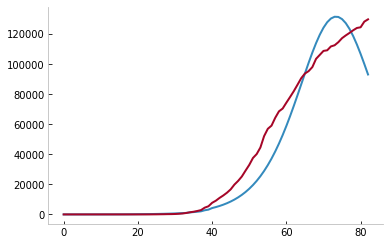

In [ ]:
plt.plot(sol)
plt.plot(data['cas_confirmes'].values)

## Posterior

In [ ]:
import theano
import theano.tensor as t
import pymc3 as pm

In [ ]:
@theano.compile.ops.as_op(itypes=[t.dscalar,t.dscalar], otypes=[t.dvector])
def solve_sir_wrap(beta, gamma):
    model = SIR(N, beta, gamma)
    res = model.solve(init_state, start_date=start_date)
    i_pred = res.loc[dates]['I']
    return np.array(i_pred)

In [ ]:
with pm.Model() as model:
      
    gamma = pm.Bound(pm.Normal, lower=0.1, upper=3)('gamma', 2, 1, testval=msol.x[1])
    beta = pm.Bound(pm.Normal, lower=0.1, upper=3)('beta', 2, 1, testval=msol.x[0])

    fitting_model = pm.Deterministic('sir', solve_sir_wrap(beta, gamma))

    # Variance related to population fraction amount! 
    #Let's assume a variance of 100 individuals, since there are cases that have been not tracked
    variance = 100**2
    sd = np.sqrt(variance)
    likelihood_model = pm.Normal(
        'likelihood_model', 
        mu=fitting_model, 
        sd=sd, 
        observed=np.array(data['cas_confirmes'])
    )

    # The Monte Carlo procedure driver
    # step = pm.Metropolis()
    sir_trace = pm.sample(800,tune=500,cores=2)

Sampling 2 chains: 100%|██████████| 2600/2600 [1:33:04<00:00,  2.15s/draws]
ERROR:pymc3:The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [ ]:
with model:
  map_estimate = pm.find_MAP(model=model)

logp = -5.1613e+05: 100%|██████████| 66/66 [00:12<00:00,  5.18it/s]  


In [ ]:
map_estimate

{'beta': array(2.29946828),
 'beta_interval__': array(1.14413128),
 'gamma': array(2.15465618),
 'gamma_interval__': array(0.88812037),
 'sir': array([2.00000000e+00, 3.08818159e+00, 3.56938648e+00, 4.12557221e+00,
        4.76842182e+00, 5.51143855e+00, 7.36283319e+00, 8.51009844e+00,
        9.83612197e+00, 1.13687543e+01, 1.51876142e+01, 1.75540417e+01,
        2.02891604e+01, 2.34504027e+01, 3.13270966e+01, 3.62079117e+01,
        4.83688875e+01, 6.46132871e+01, 8.63114432e+01, 1.15292920e+02,
        1.53999919e+02, 1.77980168e+02, 2.05691542e+02, 2.37713571e+02,
        2.74715463e+02, 3.17469870e+02, 3.66868722e+02, 4.23941448e+02,
        4.89875893e+02, 5.66042347e+02, 6.54021083e+02, 7.55633897e+02,
        8.72980167e+02, 1.00847802e+03, 1.34548226e+03, 1.55387307e+03,
        1.79431271e+03, 2.07165416e+03, 2.76009715e+03, 3.18484298e+03,
        4.23701704e+03, 4.88462890e+03, 5.62898767e+03, 6.48380746e+03,
        7.46450232e+03, 8.58831499e+03, 9.87442539e+03, 1.1344025

In [ ]:
with open('model.pymc3', 'wb') as buff:
    pickle.dump({'model': model, 'trace': sir_trace}, buff)

In [ ]:
# with open('model.pymc3', 'rb') as buff:
#     data = pickle.load(buff)
# model = data['model']
# sir_trace = data['trace']

In [ ]:
def plot_trace(varname, xlim_=(0,10)):
  trace = pd.DataFrame({
    'chaine_1': sir_trace.get_values(varname, chains=[0]),
    'chaine_2': sir_trace.get_values(varname, chains=[1])
  })

  trace_ = (
      trace
      .reset_index()
      .melt(id_vars=['index'], var_name='chains', value_name='value')
  )

  g = (
      ggplot(trace_, aes(x='value', color='chains', fill='chains'))
      + geom_density(alpha=0.1)
      + xlim(xlim_[0], xlim_[1])
  )
  return g

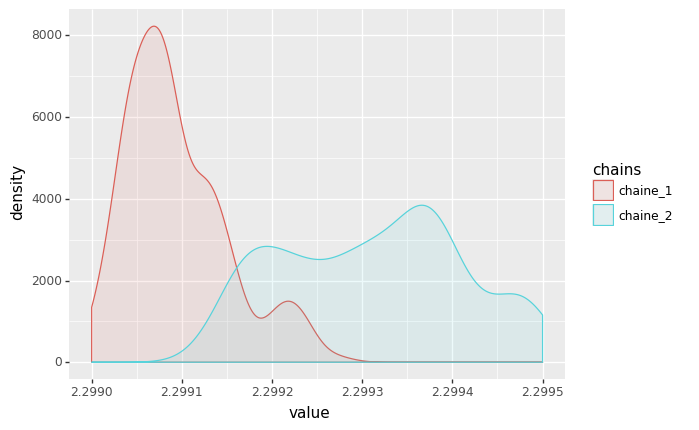

<ggplot: (-9223363295141116202)>

In [ ]:
plot_trace('beta', xlim_=(2.299, 2.2995))

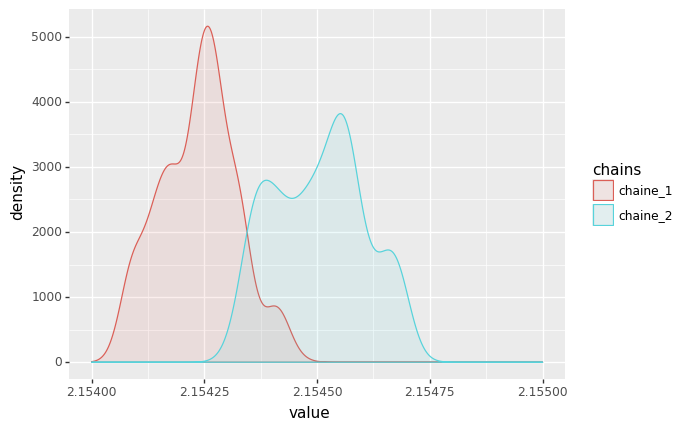

<ggplot: (-9223363295139957230)>

In [ ]:
plot_trace('gamma', xlim_=(2.154,2.155))

In [ ]:
y_min_sir = np.percentile(sir_trace['sir'], 2.5, axis=0)
y_max_sir = np.percentile(sir_trace['sir'], 100 - 2.5, axis=0)
y_fit_sir = np.percentile(sir_trace['sir'], 50, axis=0)

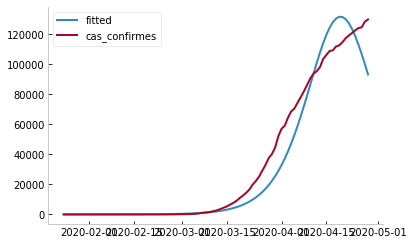

In [ ]:
t = dates.to_pydatetime()
plt.plot(t, sir_trace['sir'].mean(axis=0), label='fitted')
plt.fill_between(t, y_max_sir, y_min_sir, alpha=0.3) 
plt.plot(t, data['cas_confirmes'].values, label='cas_confirmes')
plt.legend()
plt.show()

In [ ]:
with model:
    post_pred = pm.sample_posterior_predictive(sir_trace, samples=500)

100%|██████████| 500/500 [01:34<00:00,  5.32it/s]


In [ ]:
post_min_sir = np.percentile(post_pred['likelihood_model'], 1, axis=0)
post_max_sir = np.percentile(post_pred['likelihood_model'], 100 - 1, axis=0)
post_fit_sir = np.percentile(post_pred['likelihood_model'], 50, axis=0)

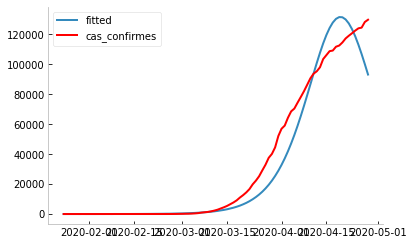

In [ ]:
t = dates.to_pydatetime()
plt.plot(t, post_fit_sir, label='fitted')
plt.fill_between(t, post_max_sir, post_min_sir, alpha=0.3) 
plt.plot(t, data['cas_confirmes'].values, color='r', label='cas_confirmes')
plt.legend()
plt.show()